In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tstrippy
from astropy import units as u
from astropy import coordinates as coord
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

## Pick a globular cluster and show the phase mixing!!

In [2]:
clusters=tstrippy.Parsers.baumgardtMWGCs()
mean,cov=clusters.getGCCovarianceMatrix("Pal5")
RA,DEC,Rsun,RV,mualpha,mu_delta,Mass,rh_m=mean

In [3]:
nsamples=100
RA,DEC,Rsun,RV,mualpha,mu_delta,Mass,rh_m=np.random.multivariate_normal(mean,cov,nsamples).T

In [4]:
# put the coordinates on the sky 
skycoords=coord.sky_coordinate.SkyCoord(
    ra = RA * u.deg,
    dec = DEC * u.deg,
    distance = Rsun * u.kpc,
    radial_velocity = RV * u.km / u.s,
    pm_ra_cosdec = mualpha * u.mas / u.yr,
    pm_dec = mu_delta * u.mas / u.yr,)
galactocentric=skycoords.transform_to(coord.Galactocentric)

In [5]:
# measure the energy of each 
MWparams=tstrippy.Parsers.pouliasis2017pii()
_,_,_,phi = tstrippy.potentials.pouliasis2017pii(MWparams,galactocentric.x.value,galactocentric.y.value,galactocentric.z.value)
T = 0.5 * (galactocentric.v_x.value**2 + galactocentric.v_y.value**2 + galactocentric.v_z.value**2)
E = T + phi

In [6]:
# sort based on the orbital energy
sortidx = np.argsort(E)
# sort the coordinates
galactocentric = galactocentric[sortidx]

In [7]:
# get the dynamical time 
r = np.sqrt(galactocentric.x.value**2 + galactocentric.y.value**2 + galactocentric.z.value**2)
v = np.sqrt(galactocentric.v_x.value**2 + galactocentric.v_y.value**2 + galactocentric.v_z.value**2)
dynamical_time = r / v
dtfrac = 1/1000
norbits = 7
t_char = np.mean(dynamical_time) 
integration_time = norbits*2*np.pi*t_char
dt = dtfrac * t_char
NSTEP = int(integration_time / dt)
integrationparams = [0,dt,NSTEP]

In [8]:
# set the initial kinematics 
x,y,z,= galactocentric.x.value,galactocentric.y.value,galactocentric.z.value
v_x,v_y,v_z = galactocentric.v_x.value,galactocentric.v_y.value,galactocentric.v_z.value
initialkinematics = [x,y,z,v_x,v_y,v_z]

In [9]:
# start the integration 
tstrippy.integrator.deallocate()
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
tstrippy.integrator.setintegrationparameters(*integrationparams)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(NSTEP,nsamples)
timestamps = tstrippy.integrator.timestamps.copy()

In [10]:
Rt = np.sqrt(xt**2 + yt**2 )

In [11]:
unitT = u.kpc/(u.km/u.s)
toGyr=unitT.to(u.Gyr)
nplots=6
time_indexes = np.linspace(0,NSTEP-1,nplots).astype(int)
# make it log space
time_indexes = np.unique(np.logspace(0,np.log10(NSTEP-1),nplots).astype(int))
# what if I want to do exponential spacing?
time_indexes = np.unique(np.geomspace(1,NSTEP-1,nplots).astype(int))
time_indexes

array([    1,     8,    71,   610,  5183, 43981])

In [12]:
# what if I want to do sqrt sampling?
time_indexes = np.unique(np.sqrt(np.arange(1,NSTEP-1,nplots)).astype(int))
time_indexes=np.linspace(0,np.sqrt(NSTEP-1),nplots).astype(int)**2

In [13]:
# get zmax
zmax = np.max(np.abs(zt))
colors = plt.cm.rainbow(np.linspace(0,1,nsamples))

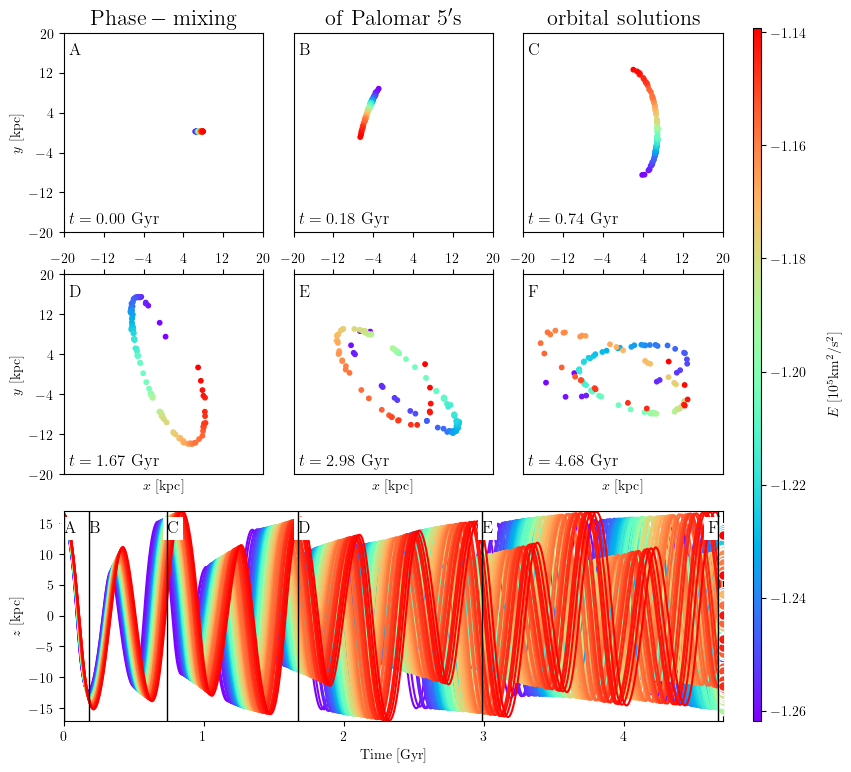

In [14]:
fig= plt.figure(figsize=(9,9))
gs = mpl.gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1], hspace=0.15,width_ratios=[1, 1,1, 1/25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0:3])
caxis = fig.add_subplot(gs[:, 3])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
nplots = len(axes)
txt = r"$t = {0:.2f}~\mathrm{{Gyr}}$"
labels = [r"$\mathrm{A}$", r"$\mathrm{B}$", r"$\mathrm{C}$", r"$\mathrm{D}$", r"$\mathrm{E}$", r"$\mathrm{F}$"]
for i,ax in enumerate(axes):
    idx = time_indexes[i]
    ax.scatter(xt[:,idx],yt[:,idx],s=10,color=colors,alpha=1)
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    mytext = txt.format(toGyr*timestamps[idx])
    ax.text(0.025, 0.025, mytext, transform=ax.transAxes, ha='left', va='bottom', fontsize=12)
    ax7.vlines(toGyr*timestamps[idx],-20,20,color='k',linestyle='-',linewidth=1,zorder=nsamples+100)
    # Add text with white background box
    ha = "right" if i == nplots-1 else "left"
    ax7.text(toGyr*timestamps[idx], 0.9*zmax, labels[i], ha=ha, va='top', fontsize=12, color='k',
             bbox=dict(facecolor='white', alpha=1, edgecolor='none', pad=3))
    ax.text(.025, 0.95, labels[i], transform=ax.transAxes, ha='left', va='top', fontsize=12, color='k',
    )

for i in range(nsamples):
    ax7.plot(toGyr*timestamps,zt[i,:],color=colors[i],label=f"Sample {i+1}")
    ax7.scatter(toGyr*timestamps[-1],zt[i,-1],marker='o',s=50,edgecolor="w",facecolor=colors[i],zorder=nsamples+10)

# pick some certain labels 
ax1.set_ylabel(r"$y~[\mathrm{kpc}]$")
ax4.set_ylabel(r"$y~[\mathrm{kpc}]$")
ax7.set_xlabel(r"$\mathrm{Time~[Gyr]}$")
ax7.set_ylabel(r"$z~[\mathrm{kpc}]$")
ax4.set_xlabel(r"$x~[\mathrm{kpc}]$")
ax5.set_xlabel(r"$x~[\mathrm{kpc}]$")
ax6.set_xlabel(r"$x~[\mathrm{kpc}]$")
ax1.set_yticks(np.arange(-20,21,8));
ax4.set_yticks(np.arange(-20,21,8));
ax4.set_xticks(np.arange(-20,21,8))
ax5.set_xticks(np.arange(-20,21,8))
ax6.set_xticks(np.arange(-20,21,8))
# Move x-ticks to the top
ax4.xaxis.tick_top()
ax5.xaxis.tick_top()
ax6.xaxis.tick_top()
# Set x-ticks for top plots
ax1.set_xticks(np.arange(-20,21,8))
ax2.set_xticks(np.arange(-20,21,8))
ax3.set_xticks(np.arange(-20,21,8))
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
# make the colorbar correspond to the energy 
norm = mpl.colors.Normalize(vmin=np.min(E)/1e5, vmax=np.max(E)/1e5)

cmap = mpl.cm.rainbow
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Only needed for older versions of matplotlib
# cbar = fig.colorbar(sm, ax=caxis, fraction=0.02, pad=0.1)
cbar = fig.colorbar(sm, cax=caxis, orientation='vertical')
ax7.set_xlim(toGyr*timestamps[0],toGyr*timestamps[-1])
ax7.set_ylim(-zmax,zmax)
cbar.set_label(r"$E~[10^5\mathrm{km^2/s^2}]$", labelpad=15)
ax1.set_title(r"$\mathrm{Phase-mixing}$", fontsize=16)
ax2.set_title(r"$\mathrm{of~Palomar~5's}$", fontsize=16)
ax3.set_title(r"$\mathrm{orbital~solutions}$", fontsize=16)
fig.savefig("../../tempImages/phase_mixing_palomar_5_orbital_solutions.png", bbox_inches='tight', dpi=300)